In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from shapely.geometry import Point, Polygon
from multiprocessing import Pool, cpu_count
from shapely.affinity import scale
from shapely.strtree import STRtree

import json
from rtree import index

import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
adata_dir = "data_level_1/adata_slide2/"
he_image_dir = "data_level_1/he_registered_old/"
pc_dir = "data_level_1/phenocycler_registered_new/"
polygon_dir  = "/data/projects/robin/segmentation/output-new-seg/segmentation_polygons.json"

with open(polygon_dir, 'r') as file:
    polygon_dict = json.load(file)

adata_with_domain = sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/adata_with_polygons.h5ad")

In [3]:
cell_names = [str(polygon_dict['geometries'][i]['cell']) for i in range(len(polygon_dict['geometries']))]
cell_coordinates = [polygon_dict['geometries'][i]['coordinates'][0] for i in range(len(polygon_dict['geometries']))]
cell_names = np.array(cell_names)
df_polygon = pd.DataFrame({
    'names' : cell_names,
    'coords' : cell_coordinates})
df_polygon.index = df_polygon['names']
df_polygon

,names,coords
names,,
185983,185983,"[[3714.5618, 20479.88], [3714.3374, 20482.264]..."
371966,371966,"[[7231.8833, 3040.58], [7232.0537, 3039.7822],..."
221120,221120,"[[7118.4053, 19706.914], [7115.494, 19704.934]..."
92533,92533,"[[1470.7107, 14148.667], [1470.7705, 14150.08]..."
76914,76914,"[[2689.5303, 12016.144], [2688.5042, 12016.396..."
...,...,...
300650,300650,"[[1215.121, 13696.862], [1213.2627, 13699.764]..."
150325,150325,"[[6032.6353, 14348.5], [6033.725, 14348.425], ..."
336545,336545,"[[7494.6553, 8513.94], [7494.7266, 8513.655], ..."


In [4]:
sample = 'X5'

# Read anndata
adata = sc.read_h5ad(adata_dir + f'{sample}.h5ad')

# Add "is_in_polygon" col. to the data
is_in_polygon = adata_with_domain.obs.loc[adata_with_domain.obs['sample'] == f'{sample}_slide2', 'is_in_polygon']
adata.obs['is_in_polygon'] = list(is_in_polygon)

# Restrict anndata to PECs in polygon
adata = adata[adata.obs['is_in_polygon']]
adata = adata[adata.obs['celltype_l1'] == 'PEC']

print(adata.shape)

(37, 480)


In [5]:
# Get the cell that exsit in both anndata and cell boundries
cell_name = [i.split('-')[1] for i in adata.obs.index]
adata.obs['cell_name'] = cell_name
adata = adata[adata.obs['cell_name'].isin(df_polygon['names'])]
df_polygon_i = df_polygon.loc[adata.obs['cell_name']]

print(adata.shape)

(37, 480)


In [6]:
# Choose the protein channel and read the data
ch = 2 # for CD44
ch = 9 # for Ki67

# Read the registered protein image
pc_image = plt.imread(pc_dir + f"Phenocycler_Channel{(ch):02}_{sample}_Level2.ome.tiff")
w, h = pc_image.shape

# Add the image to the anndata
slide_id = adata.obs['Slide_ID'][0]
adata.uns['spatial'][slide_id]['images']['Ki67'] = pc_image
adata.uns['spatial'][slide_id]['scalefactors']['tissue_Ki67_scalef'] = 1

In [7]:
# Get the shift to match cell poition on pixels
x_shift = adata.obs['x'][0] - adata.obsm['spatial'][0, 0]
y_shift = adata.obs['y'][0] - adata.obsm['spatial'][0, 1]
x_shift, y_shift

(6558.0, 5570.0)

In [8]:
adata.obs['Ki67'] = 0

pic_val_sum = {name: 0 for name in adata.obs.index}

for n, (idx, cell) in tqdm(enumerate(adata.obs.iterrows())):
    
    cell_name = idx.split('-')[1]

    coords = df_polygon_i.loc[cell_name, 'coords']
    coords = np.array(coords)
    coords[:,0] = coords[:,0] - x_shift
    coords[:,1] = coords[:,1] - y_shift
    polygon_obj = Polygon(coords)
    
    i_min, j_min = coords.min(axis=0) - 50
    i_max, j_max = coords.max(axis=0) + 50

    i_min = 0 if i_min < 0 else i_min
    j_min = 0 if j_min < 0 else j_min
    i_max = h if i_max > w else i_max
    j_max = w if j_max > h else j_max
    
    for i in range(int(i_min), int(i_max)):
        for j in range(int(j_min), int(j_max)): 
            pic_val = pc_image[j, i]
            if pic_val > 0:
                point = Point(i, j)
                if polygon_obj.covers(point):
                    pic_val_sum[idx] += pic_val

adata.obs['Ki67'] = list(pic_val_sum.values())
(adata.obs['Ki67']).sum()

37it [00:01, 36.09it/s]


561

In [9]:
(adata.obs['Ki67'] > 0).sum() / len(adata.obs['Ki67'])

0.2972972972972973

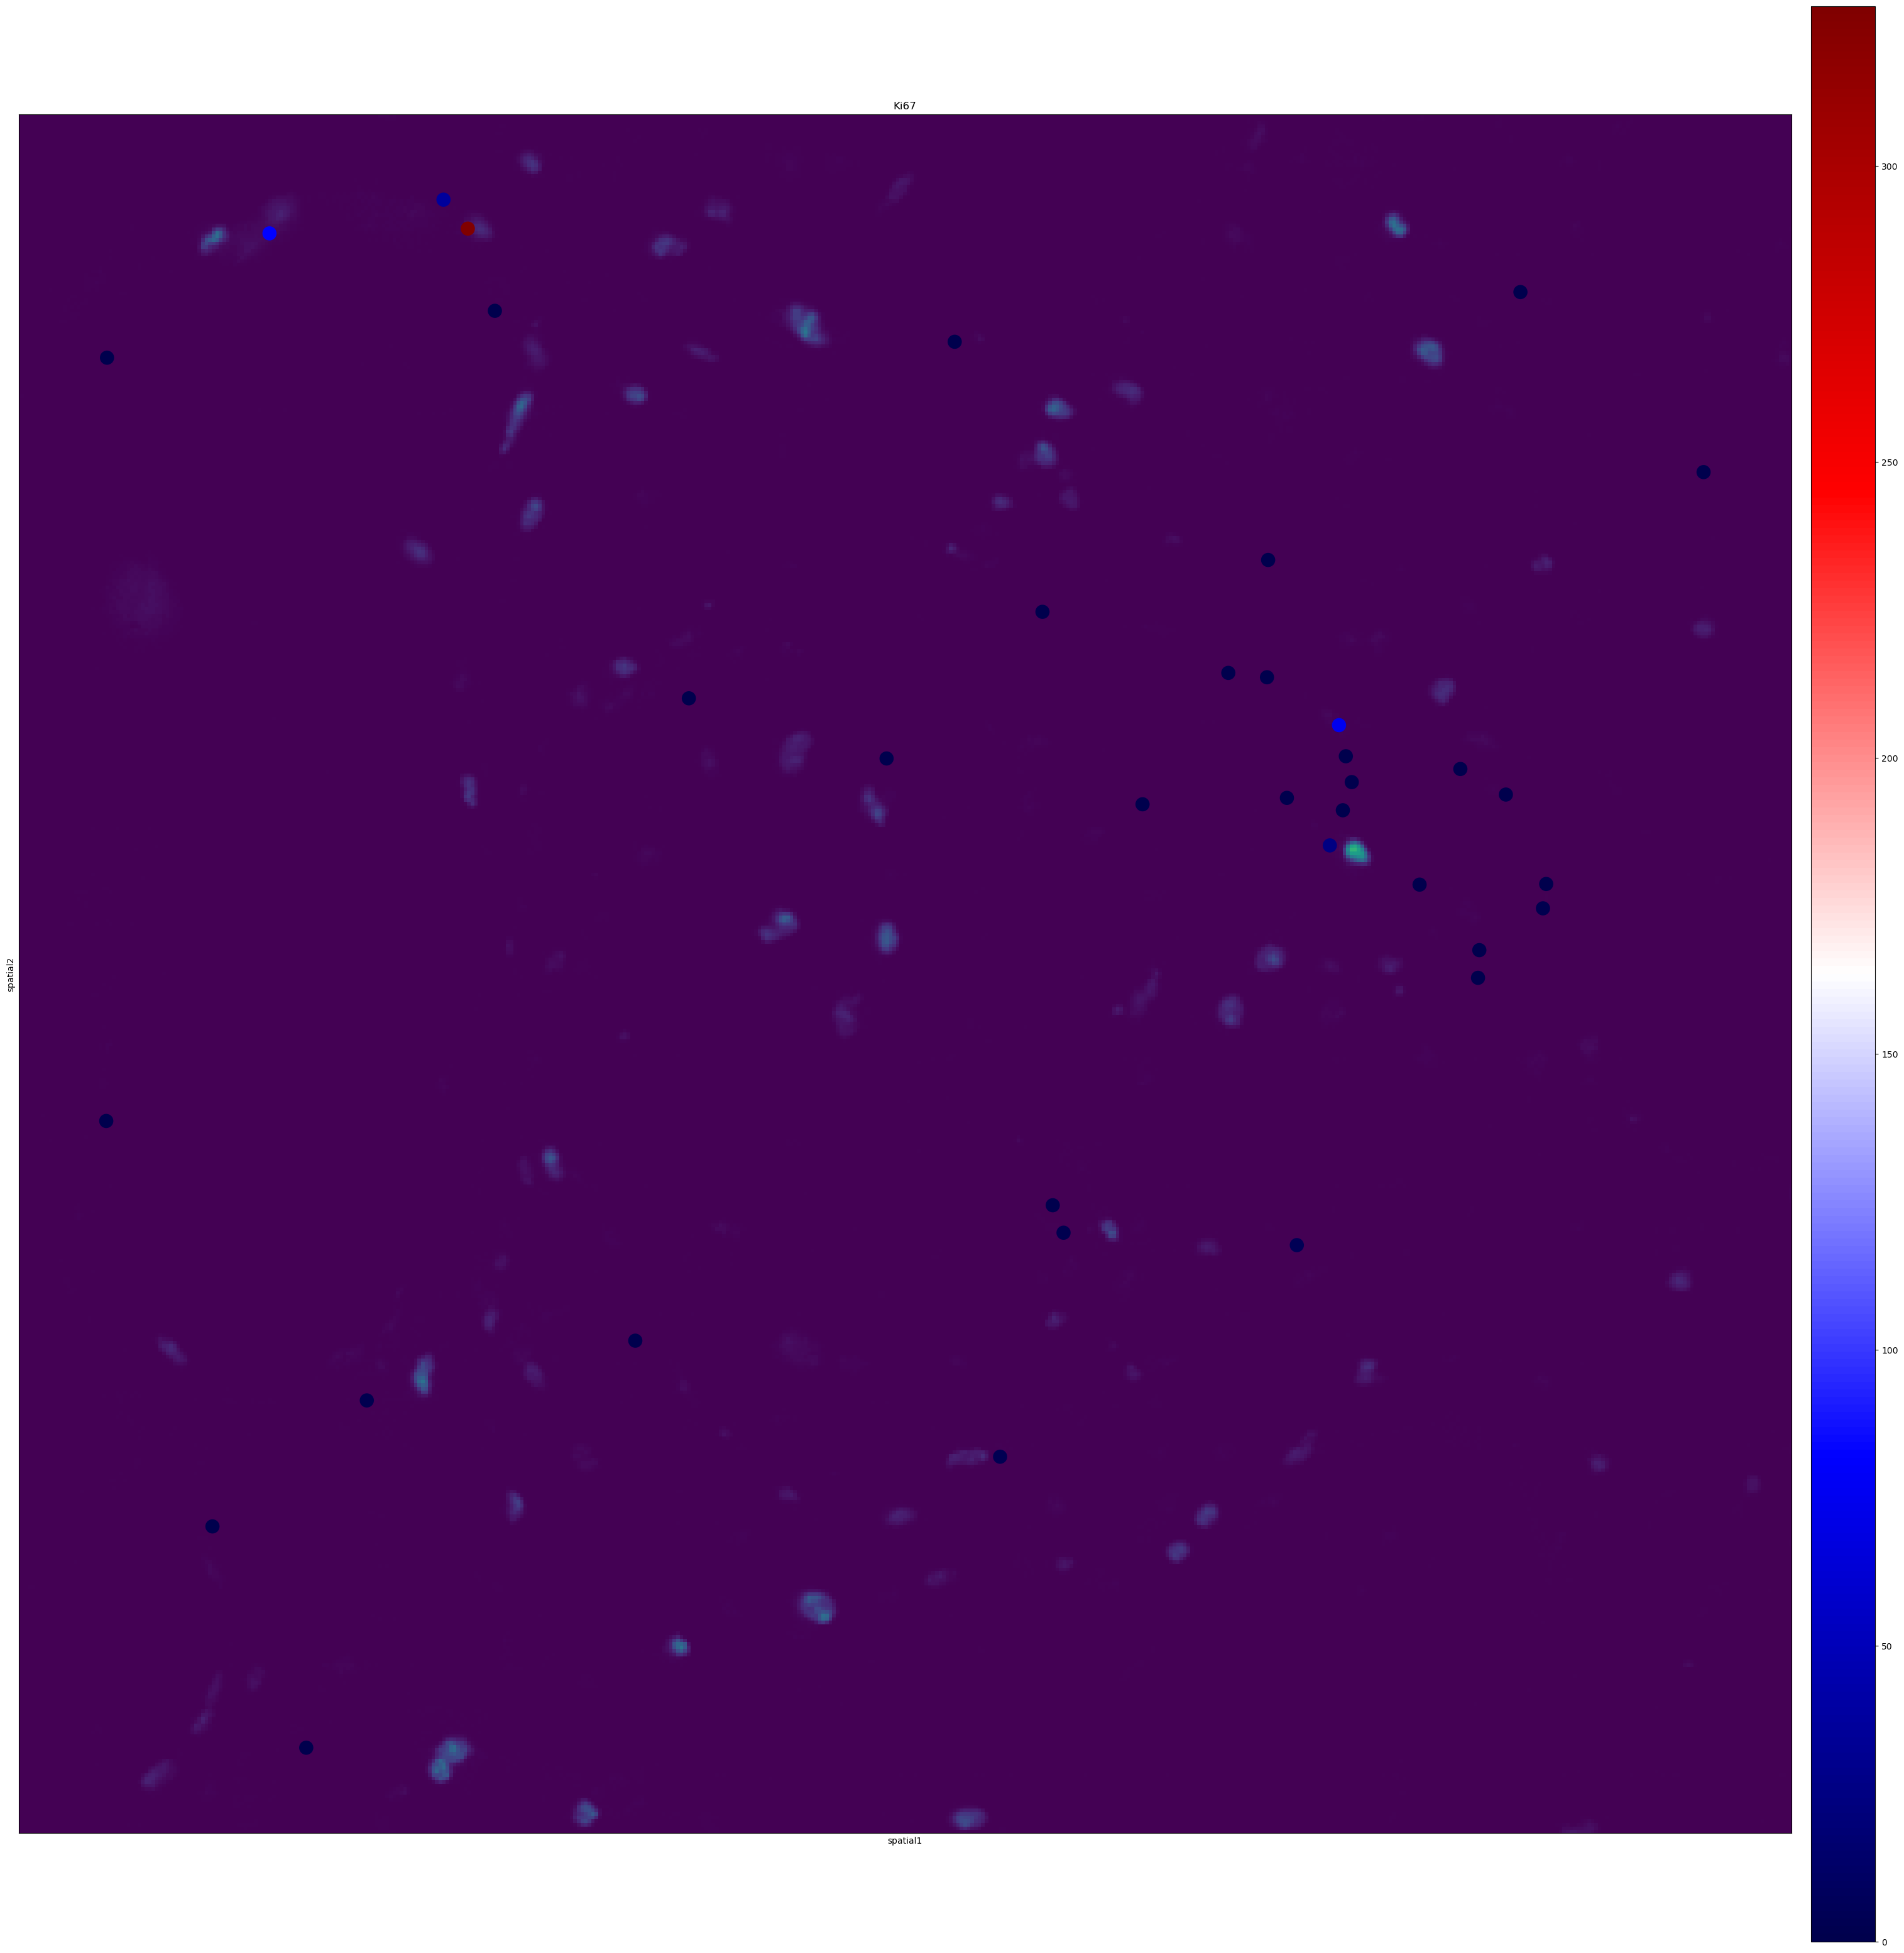

In [12]:
fig, ax = plt.subplots(figsize=(40, 40))
slide_id = adata.obs['Slide_ID'][0]

sc.pl.spatial(adata,
              library_id = slide_id,
              img_key = 'Ki67',
              color = 'Ki67',
              size = .1,
              ax = ax,
              cmap='seismic',
              show = True)

In [64]:
adata.shape

(152, 480)

In [65]:
if sample == 'X2':
    adata_all = adata
else:
    adata_all = adata_all.concatenate(adata) 
print(adata_all.shape)

(737, 480)


In [66]:
# adata_all.write_h5ad("data_level_1/adata_slide2_PECinPoly_Ki67_noX1andX8.h5ad")

In [19]:
adata = sc.read_h5ad("data_level_1/adata_slide2_PECinPoly_Ki67_noX1andX8.h5ad")
adata.obs.loc[adata.obs['sample'] == 'x2', 'Ki67'] = 0
adata.shape

(737, 480)

In [20]:
adata.obs['sample']

cell_CR9fbacb852-117027-0-0-0-0-0    x2
cell_CR9fbacb852-117054-0-0-0-0-0    x2
cell_CR9fbacb852-117111-0-0-0-0-0    x2
cell_CR9fbacb852-117175-0-0-0-0-0    x2
cell_CR9fbacb852-117395-0-0-0-0-0    x2
                                     ..
cell_CR9fbacb852-331964-1            x7
cell_CR9fbacb852-331982-1            x7
cell_CR9fbacb852-333911-1            x7
cell_CR9fbacb852-335223-1            x7
cell_CR9fbacb852-338169-1            x7
Name: sample, Length: 737, dtype: category
Categories (6, object): ['x2', 'x3', 'x4', 'x5', 'x6', 'x7']

In [21]:
disease_set = adata.obs['label'].unique()
disease_set

['ctrl', 'anca', 'gbm', 'sle']
Categories (4, object): ['anca', 'ctrl', 'gbm', 'sle']

In [22]:
disease_order = ['ctrl', 'sle', 'anca', 'gbm']
df = adata.obs
df['label'] = pd.Categorical(df['label'], categories=disease_order, ordered=True)

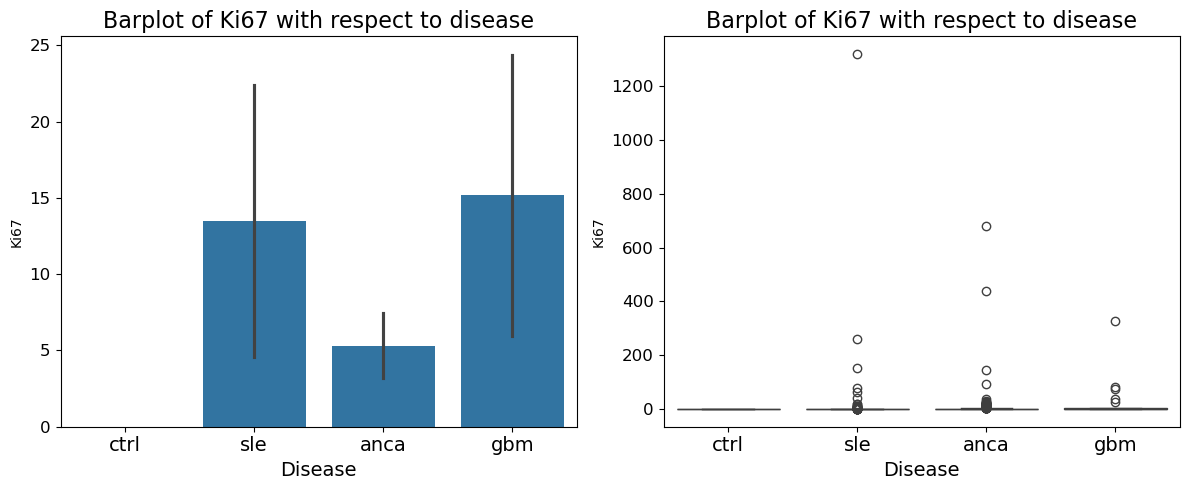

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ch = 'Ki67'
sns.barplot(x='label', y=ch, data=df, ax=axes[0], errorbar='se', order=disease_order)
axes[0].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x='label', y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

(0.0, 100.0)

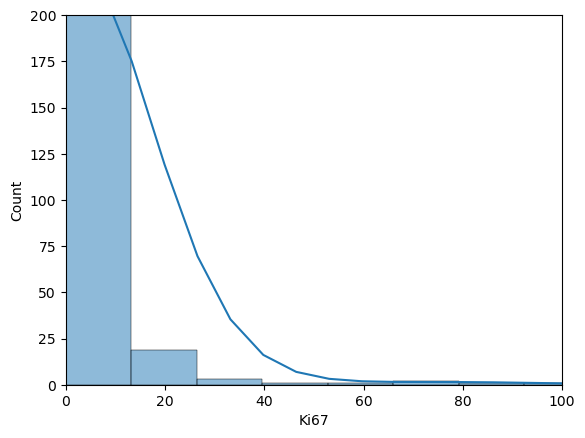

In [24]:
sns.histplot(df[ch], bins= 100,kde = True)
plt.ylim([0, 200])
plt.xlim([0, 100])

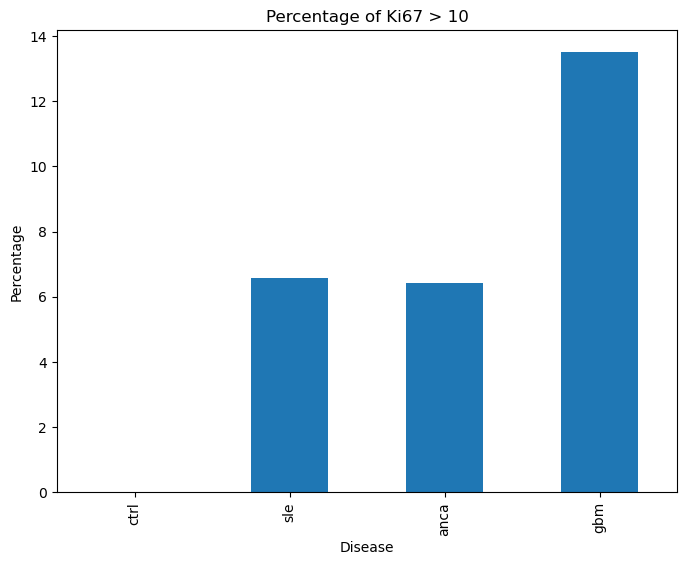

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
th = 10

df = df.reset_index(drop=True)
df.loc[:, 'Ki67_prc'] = [1.0 if i>th else 0.0 for i in df['Ki67']]
df['Ki67_prc'].sum()

ch = 'Ki67_prc'
percent = df.groupby('label')[ch].mean() * 100
percent = percent.reindex(disease_order)
percent.plot(kind='bar', figsize=(8, 6))

plt.title(f'Percentage of Ki67 > {th}')
plt.xlabel('Disease')
plt.ylabel('Percentage')
plt.show()

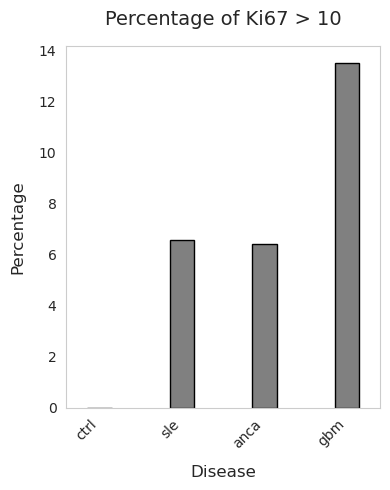

In [46]:
ch = 'Ki67_prc'
percent = df.groupby('label')[ch].mean() * 100
percent = percent.reindex(disease_order)

# Create the bar plot
fig, ax = plt.subplots(figsize=(4, 5))
percent.plot(kind='bar', ax=ax, color='gray', width=0.3, edgecolor='black')

# Customize the plot appearance
plt.title(f'Percentage of Ki67 > {th}', fontsize=14, pad=15)
plt.xlabel('Disease', fontsize=12, labelpad=10)
plt.ylabel('Percentage', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust spacing to avoid label cut-offs
ax.grid(False)
# Show the plot
plt.show()

In [28]:
adata.shape

(737, 480)

In [29]:
adata_cd44 = sc.read_h5ad("data_level_1/adata_slide2_PECinPoly_CD44_noX1andX8.h5ad")
adata_cd44.shape

(737, 480)

In [32]:
adata.obs['CD44'] = adata_cd44.obs['CD44'] 
adata.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,celltype_l1_codes,celltype_l1_prob,Slide_ID,sample,label,is_in_polygon,cell_name,Ki67,batch,CD44
cell_CR9fbacb852-117027-0-0-0-0-0,731.995284,17253.393345,27.182197,4,29,2.0680,3.810,14.02,0.9976,0.8966,...,28,0.999744,0011186,x2,ctrl,True,117027,0,0,0
cell_CR9fbacb852-117054-0-0-0-0-0,736.203982,17252.430278,29.038878,4,36,1.9740,1.230,18.24,0.9980,0.8906,...,28,1.000000,0011186,x2,ctrl,True,117054,0,0,0
cell_CR9fbacb852-117111-0-0-0-0-0,742.897142,17254.947588,30.149561,4,17,1.1180,3.848,15.20,0.9965,0.9412,...,28,0.998358,0011186,x2,ctrl,True,117111,0,0,0
cell_CR9fbacb852-117175-0-0-0-0-0,754.476935,17258.092233,30.812929,3,30,0.7039,4.106,42.62,0.9978,0.9953,...,28,1.000000,0011186,x2,ctrl,True,117175,0,0,7
cell_CR9fbacb852-117395-0-0-0-0-0,685.508616,17373.274537,27.746661,4,41,0.8298,5.082,49.41,0.9951,0.9698,...,28,0.686566,0011186,x2,ctrl,True,117395,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CR9fbacb852-331964-1,6298.832975,2771.171592,39.646133,4,12,3.3430,1.517,3.59,0.9983,0.8467,...,28,0.494506,0011186,x7,sle,True,331964,0,1,2
cell_CR9fbacb852-331982-1,7177.630189,2292.395295,38.123750,4,19,1.4130,4.763,13.45,0.9974,0.7779,...,28,0.788032,0011186,x7,sle,True,331982,0,1,9
cell_CR9fbacb852-333911-1,6205.432373,1881.687145,37.128955,1,11,0.6159,1.746,17.86,0.9775,0.8491,...,28,0.895368,0011186,x7,sle,True,333911,0,1,4
cell_CR9fbacb852-335223-1,7445.480690,2412.013745,35.699197,4,20,1.1610,7.309,17.22,0.9853,0.8610,...,28,0.999999,0011186,x7,sle,True,335223,0,1,6


In [34]:
# adata.write_h5ad("data_level_1/adata_slide2_PECinPoly_Ki67_CD44_noX1andX8.h5ad")